In [37]:
import sys  
sys.path.append("..") 
import torch
import torch.nn as nn
from data_process import get_data_loaders, getFeatures
from model.TCN import TemporalConvNet, TCN
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
data = pd.read_csv('../flights.csv') 
select_features = ['payload', 'wind_speed', 'wind_angle', 'linear_acceleration_x', 'linear_acceleration_y', 'linear_acceleration_z', 'power']
data, train_loader, val_loader, test_loader, d_split = get_data_loaders(data, 20, 10, test_size=0.2, val_size=0.2, 
                                                                        features=select_features, covariates=False)
# features = getFeatures()

In [39]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape)
    print(y.shape)
    break

torch.Size([64, 20, 7])
torch.Size([64, 10])


In [44]:
class LSTM_LSTM(nn.Module):
    def __init__(self, encoder_input_size, decoder_input_size, input_len, output_len, lstm_num_hidden, num_layers=1, covariate_size=0, covariate=False):
        super(LSTM_LSTM, self).__init__()
        if covariate:
            assert covariate_size > 0
        self.encoder = nn.LSTM(encoder_input_size, lstm_num_hidden, num_layers, batch_first=True)
        self.decoder = nn.LSTM(decoder_input_size, lstm_num_hidden, num_layers, batch_first=True)
        if covariate:
            self.fc = nn.Linear(lstm_num_hidden+covariate_size, decoder_input_size)
        else:
            self.fc = nn.Linear(lstm_num_hidden, decoder_input_size)
        self.input_len = input_len
        self.output_len = output_len
        self.decoder_input_size = decoder_input_size
        self.covariate = covariate

    def forward(self, x, covariates=None):
        """
        By default, the last feature of the encoder input is the target feature.
        And the decoder_input = encoder_input[-decoder_input_size:]
        """
        # x: (batch_size, input_len, input_size)
        _, (h, c) = self.encoder(x)
        xt = x[:, -1, -self.decoder_input_size:].unsqueeze(1)
        if self.decoder_input_size == 1:
            xt = xt.unsqueeze(2)
        outputs = []
        for t in range(self.output_len):
            output, (h, c) = self.decoder(xt, (h, c))
            if self.covariate:
                output = torch.cat((output, covariates[:, t, :].unsqueeze(1)), dim=2)
            output = self.fc(output)
            outputs.append(output[:, :, -1].unsqueeze(2))
            xt = output  # use the decoder output as the next input

        outputs = torch.cat(outputs, dim=1)
        return outputs

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

input_size = len(select_features)
output_size = len(select_features)
input_len = 20
output_len = 10
hidden_size = 32  
num_layers = 1

# encoder = Encoder(input_size, input_len, [64,64,64], hidden_size)
# decoder = Decoder(hidden_size, output_len, hidden_size, num_layers=num_layers)
seq2seq = LSTM_LSTM(input_size, output_size, input_len, output_len, hidden_size, num_layers=num_layers).to(device)

cuda


In [46]:
total_params = sum(p.numel() for p in seq2seq.parameters())
trainable_params = sum(p.numel() for p in seq2seq.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")

Total Parameters: 10727
Trainable Parameters: 10727


In [47]:
# train the model
# Loss and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(seq2seq.parameters(), lr=0.002)

# Training loop with validation and early stopping
num_epochs = 20
best_epoch = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # Training phase
    seq2seq.train()
    total_train_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.set_postfix({'train_loss': loss.item()})

    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Average Training Loss: {average_train_loss:.6f}")

    # Validation phase
    seq2seq.eval()
    total_val_loss = 0
    progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]")
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1) # (batch_size, output_len)

        loss = criterion(outputs, targets)

        total_val_loss += loss.item()
        progress_bar.set_postfix({'val_loss': loss.item()})
    
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Validation Loss: {average_val_loss:.6f}")

    # Save the model with least validation loss
    if average_val_loss < best_val_loss:
        best_epoch = epoch + 1
        best_val_loss = average_val_loss
        torch.save(seq2seq.state_dict(), f'LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt')


Epoch 1/20 [TRAIN]: 100%|██████████| 2296/2296 [00:24<00:00, 95.23it/s, train_loss=0.173]   


Epoch 1/20, Average Training Loss: 0.005742


Epoch 1/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 217.10it/s, val_loss=0.0321]


Epoch 1/20, Average Validation Loss: 0.035211


Epoch 2/20 [TRAIN]: 100%|██████████| 2296/2296 [00:22<00:00, 103.25it/s, train_loss=0.00115]


Epoch 2/20, Average Training Loss: 0.004295


Epoch 2/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 216.51it/s, val_loss=0.0046] 


Epoch 2/20, Average Validation Loss: 0.003867


Epoch 3/20 [TRAIN]: 100%|██████████| 2296/2296 [00:22<00:00, 103.08it/s, train_loss=0.0127] 


Epoch 3/20, Average Training Loss: 0.003880


Epoch 3/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 222.51it/s, val_loss=0.00533]


Epoch 3/20, Average Validation Loss: 0.003859


Epoch 4/20 [TRAIN]: 100%|██████████| 2296/2296 [00:22<00:00, 102.40it/s, train_loss=0.0182] 


Epoch 4/20, Average Training Loss: 0.003713


Epoch 4/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 209.95it/s, val_loss=0.00465]


Epoch 4/20, Average Validation Loss: 0.004424


Epoch 5/20 [TRAIN]: 100%|██████████| 2296/2296 [00:22<00:00, 102.96it/s, train_loss=0.00251]


Epoch 5/20, Average Training Loss: 0.003523


Epoch 5/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 220.27it/s, val_loss=0.00493]


Epoch 5/20, Average Validation Loss: 0.003456


Epoch 6/20 [TRAIN]: 100%|██████████| 2296/2296 [00:22<00:00, 102.92it/s, train_loss=0.0285] 


Epoch 6/20, Average Training Loss: 0.003483


Epoch 6/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 220.36it/s, val_loss=0.0086] 


Epoch 6/20, Average Validation Loss: 0.005664


Epoch 7/20 [TRAIN]: 100%|██████████| 2296/2296 [00:22<00:00, 103.34it/s, train_loss=0.000667]


Epoch 7/20, Average Training Loss: 0.003334


Epoch 7/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 224.17it/s, val_loss=0.00474]


Epoch 7/20, Average Validation Loss: 0.003096


Epoch 8/20 [TRAIN]: 100%|██████████| 2296/2296 [00:21<00:00, 104.65it/s, train_loss=0.000352]


Epoch 8/20, Average Training Loss: 0.003212


Epoch 8/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 217.61it/s, val_loss=0.00532]


Epoch 8/20, Average Validation Loss: 0.003414


Epoch 9/20 [TRAIN]: 100%|██████████| 2296/2296 [00:22<00:00, 103.75it/s, train_loss=0.000564]


Epoch 9/20, Average Training Loss: 0.003175


Epoch 9/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 236.71it/s, val_loss=0.0044] 


Epoch 9/20, Average Validation Loss: 0.003167


Epoch 10/20 [TRAIN]: 100%|██████████| 2296/2296 [00:24<00:00, 95.22it/s, train_loss=0.0013] 


Epoch 10/20, Average Training Loss: 0.003098


Epoch 10/20 [VAL]: 100%|██████████| 769/769 [00:03<00:00, 197.41it/s, val_loss=0.00449]


Epoch 10/20, Average Validation Loss: 0.003016


Epoch 11/20 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.61it/s, train_loss=0.000385]


Epoch 11/20, Average Training Loss: 0.003044


Epoch 11/20 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 153.09it/s, val_loss=0.00562]


Epoch 11/20, Average Validation Loss: 0.003876


Epoch 12/20 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 73.76it/s, train_loss=0.00695]


Epoch 12/20, Average Training Loss: 0.002987


Epoch 12/20 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 171.92it/s, val_loss=0.00519]


Epoch 12/20, Average Validation Loss: 0.003256


Epoch 13/20 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 73.56it/s, train_loss=0.00177]


Epoch 13/20, Average Training Loss: 0.002950


Epoch 13/20 [VAL]: 100%|██████████| 769/769 [00:06<00:00, 120.27it/s, val_loss=0.00413]


Epoch 13/20, Average Validation Loss: 0.002906


Epoch 14/20 [TRAIN]: 100%|██████████| 2296/2296 [00:31<00:00, 72.14it/s, train_loss=0.00261]


Epoch 14/20, Average Training Loss: 0.002901


Epoch 14/20 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 170.55it/s, val_loss=0.00419]


Epoch 14/20, Average Validation Loss: 0.002922


Epoch 15/20 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.75it/s, train_loss=0.000389]


Epoch 15/20, Average Training Loss: 0.002850


Epoch 15/20 [VAL]: 100%|██████████| 769/769 [00:05<00:00, 151.55it/s, val_loss=0.00435]


Epoch 15/20, Average Validation Loss: 0.002895


Epoch 16/20 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 81.83it/s, train_loss=0.000696]


Epoch 16/20, Average Training Loss: 0.002857


Epoch 16/20 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 189.46it/s, val_loss=0.00418]


Epoch 16/20, Average Validation Loss: 0.002898


Epoch 17/20 [TRAIN]: 100%|██████████| 2296/2296 [00:26<00:00, 87.97it/s, train_loss=0.00607]


Epoch 17/20, Average Training Loss: 0.002814


Epoch 17/20 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 189.74it/s, val_loss=0.00416]


Epoch 17/20, Average Validation Loss: 0.002797


Epoch 18/20 [TRAIN]: 100%|██████████| 2296/2296 [00:28<00:00, 79.34it/s, train_loss=0.00199]


Epoch 18/20, Average Training Loss: 0.002789


Epoch 18/20 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 183.23it/s, val_loss=0.00412]


Epoch 18/20, Average Validation Loss: 0.002920


Epoch 19/20 [TRAIN]: 100%|██████████| 2296/2296 [00:25<00:00, 88.44it/s, train_loss=0.0275] 


Epoch 19/20, Average Training Loss: 0.002748


Epoch 19/20 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 184.86it/s, val_loss=0.00479]


Epoch 19/20, Average Validation Loss: 0.003109


Epoch 20/20 [TRAIN]: 100%|██████████| 2296/2296 [00:26<00:00, 88.04it/s, train_loss=0.00201]


Epoch 20/20, Average Training Loss: 0.002760


Epoch 20/20 [VAL]: 100%|██████████| 769/769 [00:04<00:00, 188.35it/s, val_loss=0.00431]


Epoch 20/20, Average Validation Loss: 0.002745


Test loss: 0.0024508798960596323
MAPE: 12.663681983947754


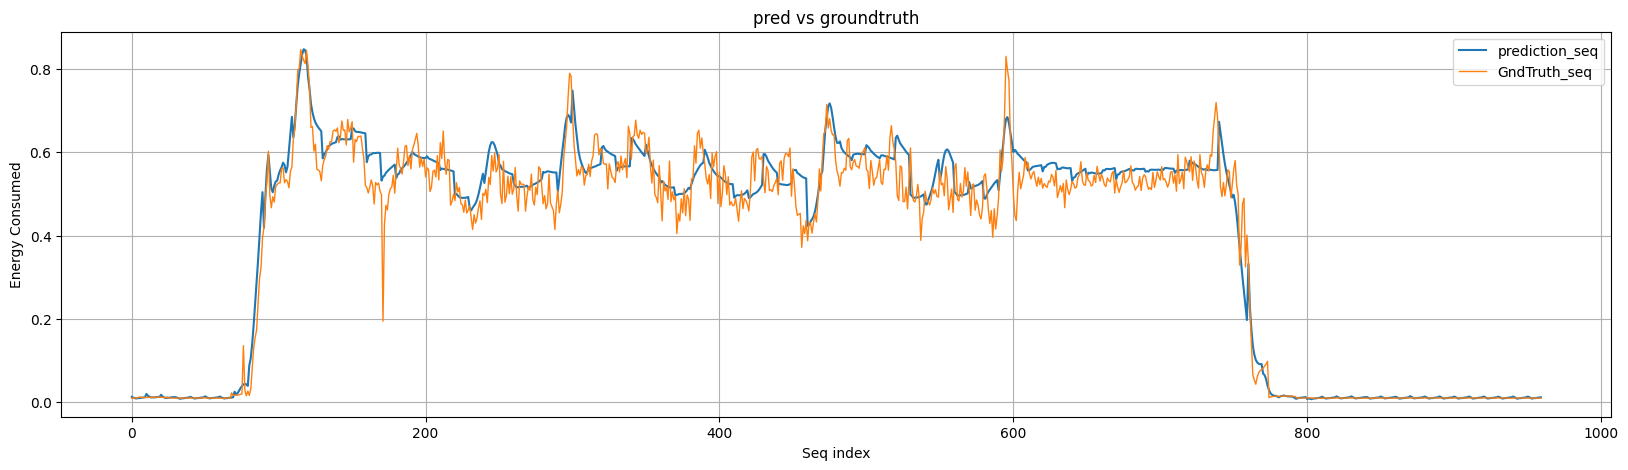

In [53]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
flight_num = 276 #random.randint(0, 100)
test_data = data[data['flight'] == flight_num]
input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                         test_data['power'].values, input_len, output_len)

input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)

with torch.no_grad():
    
    outputs = seq2seq(input_seq)  # No need for target length
    # Adjust the dimensions if necessary, based on your loss function requirements
    # Example: If your outputs and targets are both [batch_size, 2, 1]
    outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
    targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    print(f"Test loss: {error}")

    mape = torch.mean(torch.abs((outputs - targets) / targets)) * 100
    print(f"MAPE: {mape}")
    
    plot_output(outputs.cpu(), targets.cpu(), output_len)


In [54]:
from data_process import create_sequences
from utils import plot_output
from sklearn.metrics import r2_score
import random
import numpy as np
# Load the best model
seq2seq.load_state_dict(torch.load(f'LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt'))

# test the model
seq2seq.eval()
mape_list = []
sum_mape = 0
sum_size = 0
r2_score_list = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = seq2seq(inputs)  
        outputs = outputs.squeeze(-1)

    # print(r2_score(targets.cpu().T, outputs.cpu().T, multioutput='raw_values').shape)
    r2_score_list = np.append(r2_score_list, 
                              r2_score(targets.cpu().T, outputs.cpu().T, multioutput='raw_values'))
    mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
    sum_mape += mape
    sum_size += targets.shape[0]*targets.shape[1]

print(f"Test MAPE: {sum_mape/sum_size}")
print(f"Test R2 score: {np.mean(r2_score_list, axis=0)}")


Test MAPE: 19.128232955932617
Test R2 score: -37.05794702874461


In [58]:
from data_process import create_sequences
from utils import plot_output
import random
# Load the best model
seq2seq.load_state_dict(torch.load(f'LSTM_LSTM_select_best_model_{input_len}-{output_len}.pt'))

# Test the model
seq2seq.eval()
mape_list = []
flights = d_split['test']
sum_mape = 0
sum_size = 0
# flights.remove(273)
for flight_num in flights:
    # flight_num = 276 #random.randint(0, 100)
    test_data = data[(data['flight'] == flight_num) & (data['power'] > 0.02)]
    input_seq, output_seq = create_sequences(test_data[select_features].values, 
                                             test_data['power'].values, input_len, output_len)

    input_seq = torch.tensor(input_seq, dtype=torch.float32).to(device)
    output_seq = torch.tensor(output_seq, dtype=torch.float32).to(device)
    

    with torch.no_grad():
        
        outputs = seq2seq(input_seq)  # No need for target length
        # Adjust the dimensions if necessary, based on your loss function requirements
        # Example: If your outputs and targets are both [batch_size, 2, 1]
        outputs = outputs.squeeze(-1)  # Now [batch_size, 2]
        targets = output_seq

    error = nn.MSELoss()(outputs, targets)
    # print(f"Test loss: {error}")

    mape = torch.sum(torch.abs((outputs - targets) / targets)) * 100
    # print(f"MAPE: {mape}")
    sum_mape += mape
    sum_size += targets.shape[0]*targets.shape[1]
    # plot_output(outputs.cpu(), targets.cpu(), output_len)

print(f"avg MAPE: {sum_mape/sum_size}")


avg MAPE: 9.169939994812012


Dataloader

In [ ]:
"""
TODO:

1. Get rid of the head and tail of the data

2. Debug invalid data when specifying the flight number

3. By paper: 'We used a total of 114 training flights (4 hours and 4 minutes flight time), 38 validation flights 
(1 hour and 24 minutes flight time) and 37 test flights (1 hour and 23 minutes flight time).' Should we do the same?

4. Decoder input (i.e., future trajectory as inputs)

"""